#**Assignment 2: Dimensionality Reduction and Face Recognition**

## **Importing Packages**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import requests as requests
from bs4 import BeautifulSoup
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

## **Defining Helper Functions**

### Identifying Directories in a Given URL Index

In [ ]:
# https://stackoverflow.com/questions/11023530/python-to-list-http-files-and-directories/34718858
def get_url_paths(url, ext=''):
    response = requests.get(url)
    if response.ok:
        response_text = response.text
    else:
        return response.raise_for_status()
    soup = BeautifulSoup(response_text, 'html.parser')
    parent = [url + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]
    return parent

### Identifying Image Folder, Location (URL), and Number

In [ ]:
# https://www.kite.com/python/answers/how-to-replace-the-last-occurence-of-a-character-in-a-string-in-python
def identify_row_data(row, subject, ext):
    subject_num = subject[subject.rfind("s") + 1:len(subject) - 1]
    img_num = row[row.rfind("/") + 1:row.rfind(ext) - 1]
    # https://stackoverflow.com/questions/10648490/removing-first-appearance-of-word-from-a-string
    img_link = row.replace(subject, "https://resources.csed22.com", 1)
    return subject_num, img_num, img_link

### Generating a List of URLs of Images for each Subject in the Dataset 

In [ ]:
def identify_orl_data_set(url, ext):
    dataset = []
    subjects = get_url_paths(url)
    for subject in subjects:
        if "orl/s" in subject:
            subject = subject.replace("/data/iss/orl", "", 1)
            data = get_url_paths(subject, ext)
            for row in data:
                subject_num, img_num, img_link = identify_row_data(row, subject, ext)
                dataset.append([subject_num, img_num, img_link])
    return dataset

### Extracting a Binary Data Vector of 10,304 Values Corresponding to the Image Size 92x112

In [ ]:
# https://stackoverflow.com/questions/55711159/pandas-read-csv-from-url-and-include-request-header/55711425
def get_img_content(url, image_header_size):
    req = requests.get(url)
    # Convert every image into a vector of 10,304 values corresponding to the image size
    return list(req.content[image_header_size:])

### Generating the Data Matrix and the Label Vector While Importing Images Data

In [ ]:
def read_orl_data_set(dataset, sample_split):
    data = [[], []]
    label = [[], []]

    for row in dataset:
        img_content = get_img_content(url=row[2], image_header_size=14)
        if int(row[1]) % sample_split:
            data[0].append(img_content)
            label[0].append(row[0])
        else:
            data[1].append(img_content)
            label[1].append(row[0])

    # https://stackoverflow.com/questions/46051977/what-is-the-default-dtype-for-str-like-input-in-numpy
    data = {
        "TRAINING": np.array(data[0], dtype='B'),
        "TESTING": np.array(data[1], dtype='B')
    }
    label = {
        "TRAINING": np.array(label[0], dtype=int),
        "TESTING": np.array(label[1], dtype=int)
    }
    return data, label

### Plotting Accuracy versus K for each α

In [ ]:
def plot_accuracy(accuracy, k=[1, 3, 5, 7], alpha=[0.8, 0.85, 0.9, 0.95, 1]):
  for score in accuracy:
    plt.plot(k, score)
    plt.legend(alpha)

## **Creating Training and Test Sets from Dataset**

In [ ]:
dataset = identify_orl_data_set('https://resources.csed22.com/data/iss/orl', 'pgm')
data, label = read_orl_data_set(dataset, sample_split=2)

In [ ]:
print(label)


{'TRAINING': array([ 1,  1,  1,  1,  1,  1,  1, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11,
       11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 16, 16,
       16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18,
       18, 18, 19, 19, 19, 19, 19, 19, 19,  2,  2,  2,  2,  2,  2,  2, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22,
       22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24,
       25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27,
       27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29,
       29,  3,  3,  3,  3,  3,  3,  3, 30, 30, 30, 30, 30, 30, 30, 31, 31,
       31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
       33, 33, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 36,
       36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38,
       38, 3

## **Performing PCA and KNN**

### Calculating Covariance, Eigenvalues, and Eigenvectors

In [ ]:
COV = np.cov(data["TRAINING"].T, ddof=0)
w, v = np.linalg.eigh(COV)

# https://stackoverflow.com/questions/6771428/most-efficient-way-to-reverse-a-numpy-array
eigenvalue = w[::-1]
eigenvector = v[::-1]

### Finding the Number of Eigenvalues Leading to Acceptable Captured Variance for Multiple α

In [ ]:
eigen_sum = np.sum(eigenvalue, 0)

# Note: 100% alpha is always at (n-1)
alpha = [0.8, 0.85, 0.9, 0.95, 1]
eigen_num = []
for a in alpha:
    for i in range(eigenvalue.size):
        if np.sum(eigenvalue[0:i + 1], 0) / eigen_sum >= a:
            eigen_num.append(i + 1)
            break
print("Eigens: ", eigen_num, "\n")

Eigens:  [36, 51, 76, 115, 199] 



### Creating Projection Matrix

In [ ]:
projection_matrix = []
for e in eigen_num:
    pm = np.zeros((e, 10304))
    for i in range(e):
        # Note: had to truncate the imaginary part, sk-knn does not support it.
        pm[i] = eigenvector[int(i)]
    projection_matrix.append(pm.T)

### Projecting the Training and Test Sets and Running KNN Classification

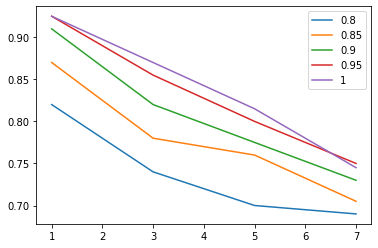

In [ ]:
accuracy_50_50 = []
for i in range(len(alpha)):
    proj_training_data = np.matmul(data["TRAINING"], projection_matrix[i])
    proj_testing_data = np.matmul(data["TESTING"], projection_matrix[i])

    scores = []

    # https://towardsdatascience.com/knn-using-scikit-learn-c6bed765be75
    for k in range(1, 8, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(proj_training_data, label["TRAINING"])
        pred = knn.predict(proj_testing_data)
        scores.append(metrics.accuracy_score(pred, label["TESTING"]))

    accuracy_50_50.append(scores)

plot_accuracy(accuracy_50_50)

## **Splitting the Data into 70% Training and 30% Test**

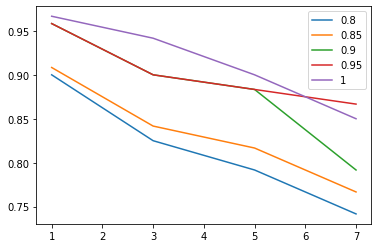

In [ ]:
data, label = read_orl_data_set(dataset, sample_split=3)

COV = np.cov(data["TRAINING"].T, ddof=0)
w, v = np.linalg.eigh(COV)

eigenvalue = w[::-1]
eigenvector = v[::-1]

eigen_sum = np.sum(eigenvalue, 0)

alpha = [0.8, 0.85, 0.9, 0.95, 1]
eigen_num = []
for a in alpha:
    for i in range(eigenvalue.size):
        if np.sum(eigenvalue[0:i + 1], 0) / eigen_sum >= a:
            eigen_num.append(i + 1)
            break

projection_matrix = []
for e in eigen_num:
    pm = np.zeros((e, 10304))
    for i in range(e):
        pm[i] = eigenvector[int(i)]
    projection_matrix.append(pm.T)

accuracy_70_30 = []
for i in range(len(alpha)):
    proj_training_data = np.matmul(data["TRAINING"], projection_matrix[i])
    proj_testing_data = np.matmul(data["TESTING"], projection_matrix[i])
    scores = []
    for k in range(1, 8, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(proj_training_data, label["TRAINING"])
        pred = knn.predict(proj_testing_data)
        scores.append(metrics.accuracy_score(pred, label["TESTING"]))

    accuracy_70_30.append(scores)

plot_accuracy(accuracy_70_30)

In [ ]:
print("Accuracy improvment: ", (np.mean(np.divide(np.array(accuracy_70_30), np.array(accuracy_50_50))) - 1) * 100, "%")

Accuracy improvment:  8.996946153644236 %
